In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch
import argparse
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from models.soft_shift_net.innerSoftShiftTriple import InnerSoftShiftTriple
#from models.accelerated_shift_net.accelerated_InnerShiftTriple import AcceleratedInnerShiftTriple
from options.train_options import TrainOptions 


# CREATE DEFAULT OPTIONS TO INITIALIZE THE SHIFTMODEL

In [2]:
dataroot = '/mnt/hdd2/AIM/DAGM/Class4_def/' # ENTER HERE THE PATH YOU WANT TO USE AS DATAROOT
options = '--dataroot {}'.format(dataroot).split(' ')

In [3]:
def get_parser(options=None):
    parser = TrainOptions()
    parser.parse(options=options)
    return parser

In [4]:
parser = get_parser(options=options)

----------------- Options ---------------
           add_mask2input: 1                             
                batchSize: 1                             
                    beta1: 0.5                           
               bottleneck: 512                           
          checkpoints_dir: ./log                         
                constrain: MSE                           
           continue_train: False                         
                 dataroot: /mnt/hdd2/AIM/DAGM/Class4_def/	[default: ./datasets/Paris/train]
             dataset_mode: aligned                       
              discounting: 1                             
              display_env: main                          
             display_freq: 10                            
               display_id: 1                             
            display_ncols: 5                             
             display_port: 8097                          
           display_server: http://localhost           

# CREATE INNER_SHIFT_TRIPLE LAYER

In [5]:
#from models.InnerShiftTriple import InnerShiftTriple

In [6]:
opt = parser.opt
#opt

In [7]:
inner_shift_triple = InnerSoftShiftTriple(opt)

In [8]:
inner_shift_triple.cuda()

InnerSoftShiftTriple( ,triple_weight 1)

# EVALUE SPEED FORWARD

### THE SIZE OF THE INPUT TENSOR IS (BATCH_SIZE, 256 * 2 (former | latter), 32, 32). LET CREATE A RANDOM TENSORS AND EVALUTE ITS FORWARD FIRST

In [9]:
import numpy as np
torch.cuda.is_available()

True

### NOW WE NEED TO SET UP THE MASK

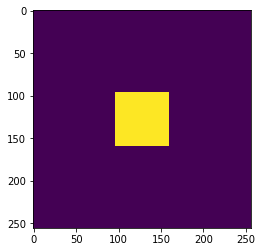

In [10]:
c, h, w = (1, 256, 256)
hh = h//2
wh = w//2
hm_size = 32
mask = np.zeros((1, c, h, w))
mask[..., hh - hm_size:hh + hm_size, wh - hm_size:wh + hm_size] = 1
#mask[..., h - hh:, :] = 1
mask_global=torch.ByteTensor(mask).cuda()#.cpu()
plt.imshow(np.squeeze(mask))

In [11]:
inner_shift_triple.set_mask(mask_global=mask_global)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)

In [12]:
x_np = np.random.normal(0, 1, (1, 512, 32, 32))
x_tr = torch.FloatTensor(x_np)

In [15]:
%time output = inner_shift_triple(x_tr.cuda())
#output = inner_shift_triple(x_tr.cuda())
#flag, indexes, ind_lst = inner_shift_triple(x_tr.cuda())

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.4 ms


In [752]:
from skimage import io
from skimage.transform import resize

In [759]:
!ls

frontend-large.jpg
images?q=tbn:ANd9GcQdZHoh1hgMFbOuCRH5_uhGhm5U29oPQJihawtfBLGCNQryUB5qew
__init__.py
log
NewModule.ipynb
OptimizingShift.ipynb


torch.Size([1, 3, 32, 32]) (1, 1, 32, 32)


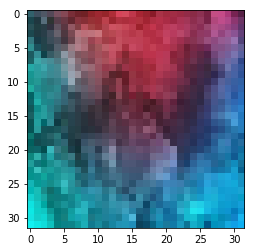

In [760]:
im_o = io.imread('images?q=tbn:ANd9GcQdZHoh1hgMFbOuCRH5_uhGhm5U29oPQJihawtfBLGCNQryUB5qew')
im_256 = resize(im_o, (256, 256))
im = resize(im_o, (32, 32))
plt.imshow(im)
im = np.array([im])
im = torch.from_numpy(im)
im = im.permute((0, 3, 1, 2))
print(im.shape, mask.shape)

In [822]:
import util.util as util

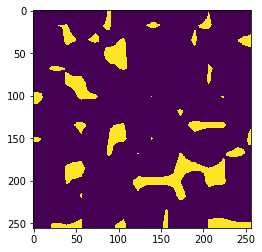

In [866]:
mask_i = util.wrapper_gmask(opt)
plt.imshow(np.squeeze(mask_i))

In [868]:
mask_i_32 = resize(np.squeeze(mask_i.numpy()), (32, 32))
print(mask_i_32.shape)
mask_i_32 = mask_i_32[np.newaxis, ...][np.newaxis, ...]


(32, 32)


(1, 1, 32, 32) <class 'numpy.ndarray'>


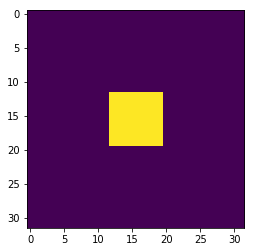

In [875]:
from torch.nn.modules.distance import PairwiseDistance
from torch import nn
c, h, w = (1, 32, 32)
hh = h//2
wh = w//2
hm_size = hh//4
mask = np.zeros((1, c, h, w))
mask[..., hh - hm_size:hh + hm_size, wh - hm_size:wh + hm_size] = 1
print(mask.shape, type(mask))
c, h, w = (1, 256, 256)
hh = h//2
wh = w//2
hm_size = hh//4
mask_256 = np.zeros((1, c, h, w))
mask_256[..., hh - hm_size:hh + hm_size, wh - hm_size:wh + hm_size] = 1
plt.imshow(np.squeeze(mask))



In [877]:
#torch.Size([4096, 61440])
print(mask_i_32.shape, mask.shape)
%time image = distance_mixing(im.clone(), torch.from_numpy(mask).cuda())

(1, 1, 32, 32) (1, 1, 32, 32)
torch.Size([1, 1, 32, 32])


ValueError: probabilities do not sum to 1

In [871]:
256 * 256 , 32 * 32, (256 * 256) / (32 * 32), 768*16

(65536, 1024, 64.0, 12288)

In [858]:
image.shape

torch.Size([1, 3, 32, 32])

In [859]:
img = np.squeeze(image.cpu().numpy()).transpose((1, 2, 0))

In [860]:
#resize(img, (256, 256))

In [861]:
m = np.squeeze(mask_256)[..., np.newaxis]

In [862]:
f_img = im_256 * (1 - m) +  resize(img, (256, 256)) * (m)

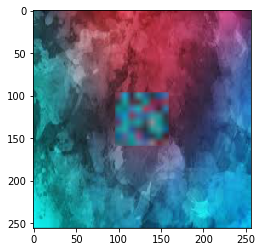

In [863]:
plt.imshow(f_img)

In [818]:
idx = tuple((np.where(flag_n == 1), f1))

NameError: name 'flag_n' is not defined

In [819]:
transition_matrx[idx] = 1

NameError: name 'transition_matrx' is not defined

In [ ]:
plt.imshow(transition_matrx)

In [ ]:
tmp = tmp[:, cp]
tmp.shape

In [ ]:
cp = np.where(flag == 0)[0][indexes][0] == flag

In [ ]:
indexes

In [ ]:
tmp[:, 0, indexes] = 1

In [ ]:
np.sum(tmp)

In [ ]:
np.sum(transition_matrx)

In [ ]:
torch.sum(flag)

In [ ]:
indexes

In [ ]:
output.shape

In [ ]:
from util import util
import torch.nn.functional as F

In [ ]:
def create_random_mask(opt):
    gMask_opts = {}
    mask_global = torch.ByteTensor(1, 1, \
                                 opt.fineSize, opt.fineSize)

        # Here we need to set an artificial mask_global(not to make it broken, so center hole is ok.)
    mask_global.zero_()
    mask_global[:, :, int(opt.fineSize/4) + opt.overlap : int(opt.fineSize/2) + int(opt.fineSize/4) - opt.overlap,\
                                int(opt.fineSize/4) + opt.overlap: int(opt.fineSize/2) + int(opt.fineSize/4) - opt.overlap] = 1  
    
    res = 0.06 # the lower it is, the more continuous the output will be. 0.01 is too small and 0.1 is too large
    density = 0.25
    MAX_SIZE = 300
    maxPartition = 30
    low_pattern = torch.rand(1, 1, int(res*MAX_SIZE), int(res*MAX_SIZE)).mul(255)
    pattern = F.upsample(low_pattern, (MAX_SIZE, MAX_SIZE), mode='bilinear').data
    low_pattern = None
    pattern.div_(255)
    pattern = torch.lt(pattern,density).byte()  # 25% 1s and 75% 0s
    pattern = torch.squeeze(pattern).byte()
    gMask_opts['pattern'] = pattern
    gMask_opts['MAX_SIZE'] = MAX_SIZE
    gMask_opts['fineSize'] = opt.fineSize
    gMask_opts['maxPartition'] = maxPartition
    gMask_opts['mask_global'] = mask_global
    mask_global = util.create_gMask(gMask_opts) # create an initial random mask.   
    return mask_global

In [ ]:
%time mask_global = create_random_mask(opt)

In [ ]:
mask_global.shape

In [ ]:
plt.imshow(np.squeeze(mask_global))

In [ ]:
mask_global

In [ ]:
inner_shift_triple.set_mask(mask_global=mask_global, threshold=opt.threshold, layer_to_last=3)

In [ ]:
%timeit output = inner_shift_triple.forward(x_tr.cuda())

# THE ENTIRE PROCESS IS PRETTY FAST, THE ISSUE WAS COMING FROM THE MASK GENERATOR

# IMPLEMENT AN ACCELERATE MODULE

In [ ]:
opt = parser.opt
opt.shift_sz = 1

In [ ]:
from models.accelerated_InnerShiftTriple import AcceleratedInnerShiftTriple
acce_inner_shift_triple = AcceleratedInnerShiftTriple(opt.threshold, opt.fixed_mask)

In [ ]:
acce_inner_shift_triple.cuda()

In [ ]:
acce_inner_shift_triple.set_mask(mask_global=mask_global, threshold=opt.threshold, layer_to_last=3)

In [ ]:
%timeit output = acce_inner_shift_triple(x_tr.cuda())

In [ ]:
acce_inner_shift_triple.__dict__

In [ ]:
print('THE SPEED UP IS {} FOLD'.format(582/115))